<a href="https://colab.research.google.com/github/bartk97/Monte-Carlo-integration/blob/master/MonteCarlo_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from scipy.stats import uniform
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### **Monte Carlo integration**

Let $f \in L^2$, then
$$I(f) = \int_{[0,1]} f(x) dx \approx \frac{1}{N} \sum_{i=1} ^N f(\xi_i) = MC_N(f),$$

where $\{ \xi_i \}_{i = 1}^N$ are independent and identically distributed $\xi_i \sim U[0,1]$.

In [27]:
class MonteCarlo:
  
    def __init__(self, n, f, q_alfa = 1.96, F = 'None'):
      self.n = n
      self.f = f
      self.q_alfa = q_alfa
      self.F =  F
    
    def fit(self):
      self.Xi = uniform.rvs(size=self.n)
      self.MC = 0.
      for xi in self.Xi:
          self.MC += self.f(xi)
      self.MC = self.MC/self.n
      return self

    def MC_(self):
      return self.MC

    def exact_(self):
      if self.F == 'None':
        self.is_known = False
        print("exact is unknown")
      else:
        self.exact = self.F(1) - self.F(0)
        self.is_known = True
        return self.exact

    def error_(self):
      self.exact_()
      if self.is_known:
        self.error = abs(self.exact- self.MC)
        return self.error
      else:
        print("exact is unknown")

    def conf_interval_(self):
      sum = 0.
      for xi in self.Xi:
          sum += (self.f(xi) - self.MC)**2
      var = (1/(self.n-1))*sum
      self.temp = var**(1/2)*self.n**(-1/2)
      self.conf_interval = [self.MC - self.q_alfa * self.temp, self.MC + self.q_alfa * self.temp]
      return self.conf_interval

    def results(self):
      print("MC = ", self.MC)

      self.conf_interval_()
      print("conf_interval = [" + str(self.conf_interval[0]) + ", " + str(self.conf_interval[1]) + "]")
      
      self.error_()
      if self.is_known:
        print("exact = ", self.exact)
        print("error = ", self.error)

**Example.** $f(x) = \sin(x)$ and $F(x) = \int_0^x sin(x) dx = \cos(x)$

In [28]:
mc = MonteCarlo(n = 1000, 
                f = lambda x: np.sin(x), 
                F = lambda x: -np.cos(x)).fit()

Monte Carlo approximation $MC_N(f)$

In [29]:
mc.MC_()

0.4605530382532835

Exact value for $I(f)$

In [30]:
mc.exact_()

0.45969769413186023

Error for approximation: $Error = |MC_N(f) - I(f)|$

In [31]:
mc.error_()

0.0008553441214232405

Confidence interval for Monte Carlo Integration

In [32]:
mc.conf_interval_()

[0.4451742003101898, 0.47593187619637717]

Summary

In [33]:
mc.results()

MC =  0.4605530382532835
conf_interval = [0.4451742003101898, 0.47593187619637717]
exact =  0.45969769413186023
error =  0.0008553441214232405


### **Error analysis**

In [34]:
def df_MC(f_test, F_test, q_alfa=1.96, iter_n=6):
  data = [] 
  N =[] 

  for i in range(iter_n):

    mc = MonteCarlo(n = 10**(i+1),
                    f = f_test,
                    q_alfa = q_alfa,
                    F = F_test).fit()

    I_left, I_right = mc.conf_interval_()
    data.append([mc.MC_(), mc.error_(), I_left, I_right])
    N.append(10**(i+1))

  return pd.DataFrame(data=data, columns=[ 'MC(f)', 'Error', 'I_alfa-', 'I_alfa+'], index = N)

In [35]:
df_MC(f_test = lambda x: np.sin(x), 
      F_test = lambda x: -np.cos(x))

,MC(f),Error,I_alfa-,I_alfa+
10,0.419198,0.040500,0.243539,0.594858
100,0.477361,0.017664,0.431358,0.523364
1000,0.459878,0.000180,0.444334,0.475422
10000,0.458835,0.000863,0.453940,0.463730
100000,0.460526,0.000828,0.458992,0.462059
1000000,0.459620,0.000078,0.459134,0.460105


### **Linear Regression for $L^2$-error $\sim N$**

In [36]:
def linearRegression_MC(f_test, F_test, iter_n=1000, iter_k=5):  
  Errors = []
  for i in range(iter_k):
    sum = 0
    for j in range(iter_n):

      mc = MonteCarlo(n = 10**(i+1),
                    f = f_test,
                    F = F_test).fit()
      sum = sum + mc.error_()**2

    Errors.append(np.sqrt((1/iter_n * sum)))

  y = []
  for E_i in Errors:
   y.append(np.log10(abs(E_i)))

  y = np.asarray(y)
  x = np.array(range(1, iter_k+1)).reshape((-1, 1))
  model = LinearRegression().fit(x, y)

  plt.scatter(x, y,  color='red')
  plt.plot(x, model.predict(x), color='blue', linewidth=1)
  plt.show()
  print("\n\nslope = ", model.coef_[0])

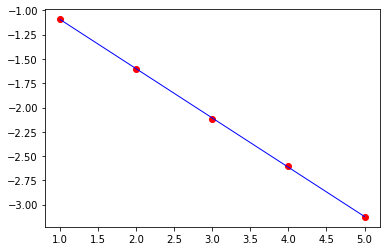



slope =  -0.5073190538005057


In [37]:
linearRegression_MC(f_test = lambda x: np.sin(x), 
                    F_test = lambda x: -np.cos(x))